In [1]:
import os

import copy as cp
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import getdist as gd
import getdist.plots as gdp

%matplotlib inline

from lyaemu import likelihood as lyl
from lyaemu import lyman_data as lyd


/share/apps/anaconda/python3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/keir/Software/lya_emulator/lyaemu/SimulationRunner/SimulationRunner/cambpower.py:8: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/share/apps/anaconda/python3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/share/apps/anaconda/python3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/share/apps/an

In [2]:
basedir = '/share/data2/keir/Simulations/nCDM_emulator_512'
emulator_json = 'emulator_params_batch3_TDR_u0.json'
use_measured_params = True
redshift_dependent_params = True

lyman_data_instance = lyd.BoeraData()
z = lyman_data_instance.redshifts_unique[::-1]


likelihood_instance = lyl.UltraLightAxionLikelihoodClass(basedir, mean_flux='free_high_z', max_z=np.max(z),
                                                         redshifts=z, pixel_resolution_km_s=1., emulator_class='nCDM',
                                                         emulator_json_file=emulator_json,
                                                         use_measured_parameters=use_measured_params,
                                                         redshift_dependent_parameters=redshift_dependent_params,
                                                         data_class='Boera',
                                                         dark_matter_model=lyl.ultra_light_axion_numerical_model,
                                                         fix_parameters={'omega_m': 0.3209})

likelihood_instance.data_fluxpower = likelihood_instance.lyman_data_flux_power[::-1].flatten()


Beginning to generate emulator at 2020-04-14 10:13:50.286455
k_max_emulated_h_Mpc = 28.093018599498517 0.19952623149688797 4.95 0.33
dpvals = [[0.73805814]
 [0.79181238]
 [0.84556662]
 [0.89932086]
 [0.95307511]
 [1.00682935]
 [1.06058359]
 [1.11433784]
 [1.16809208]
 [1.22184632]]
nuggets = [0.         0.00075592 0.00151184 0.00226776 0.00302368 0.0037796
 0.00453551 0.00529143 0.00604735 0.00680327 0.00755919 0.00831511
 0.00907103 0.00982695 0.01058287 0.01133879 0.0120947  0.01285062
 0.01360654 0.01436246 0.01511838 0.0158743  0.01663022 0.01738614
 0.01814206 0.01889798 0.0196539  0.02040981 0.02116573 0.02192165
 0.02267757 0.02343349 0.02418941 0.02494533 0.02570125 0.02645717
 0.02721309 0.027969   0.02872492 0.02948084 0.03023676 0.03099268
 0.0317486  0.03250452 0.03326044 0.03401636 0.03477228 0.0355282
 0.03628411 0.03704003 0.03779595 0.03855187 0.03930779 0.04006371
 0.04081963 0.04157555 0.04233147 0.04308739 0.0438433  0.04459922
 0.04535514 0.04611106 0.04686698 0.047

In [3]:
#Prior function
prior_gaussian_param_names = np.array(['tau0_0', 'tau0_1', 'tau0_2', 'ns', 'As', 'T_0_z_5.0', 'T_0_z_4.6',
                                      'T_0_z_4.2'])
prior_gaussian_mean = np.array([1., 1., 1., 0.9635, 1.8296e-9, 8022., 7651., 8673.])
prior_gaussian_std = np.array([0.05, 0.05, 0.05, 0.0057, 0.030 * 1.e-9, 3000., 3000., 3000.])
prior_gaussian = lambda params: likelihood_instance.log_gaussian_prior(params, prior_gaussian_param_names,
                                                                       prior_gaussian_mean, prior_gaussian_std)

prior_max_jump_param_names = np.array(['T_0', 'u_0'])
prior_max_jumps = np.array([5000., 10.])
prior_max_jump = lambda params: likelihood_instance.log_redshift_prior(params, prior_max_jump_param_names,
                                                                       prior_max_jumps)

prior_convex_hull_param_names = [['T_0_z_5.0', 'u_0_z_5.0'], ['T_0_z_4.6', 'u_0_z_4.6'], ['T_0_z_4.2', 'u_0_z_4.2']]
prior_convex_hull = lambda params: likelihood_instance.log_convex_hull_prior(params, prior_convex_hull_param_names)

prior_functions = [prior_gaussian, prior_max_jump, prior_convex_hull]


In [6]:
#Test high likelihood
test_params = np.array([0.9635, 1.8296e-9, 8022., 7651., 8673., 1.44, 1.48, 1.45, 4.56, 6.11, 7.24, -19.1])
test_params_mf = np.concatenate((np.array([1., 1., 1.]), test_params)) #0.77, 0.78, 0.93
test_params_mf.shape


(15,)

In [20]:
test_params_mf = posterior_MCsamples0[-1].getMeans()
test_params_mf


array([ 9.11576128e-01,  9.95445657e-01,  1.08208181e+00,  9.64930098e-01,
        1.82224827e-09,  1.18415713e+04,  1.02243883e+04,  7.53407937e+03,
        1.58756444e+00,  1.42929020e+00,  8.60373274e-01,  1.91780581e+01,
        1.50609687e+01,  1.13269041e+01, -1.91639184e+01])

In [45]:
#Remove optimisation simulation from emulator.sample_params
likelihood_instance.emulator.sample_params = likelihood_instance.emulator.sample_params[:-1]


In [46]:
likelihood_instance.emulator.sample_params.shape


(64, 10)

In [50]:
#Optimise acquisition function
optimise_bounds = [(0.05, 0.95) for i in range(test_params_mf.size)]
optimise_bounds[-1] = (0.05, 0.99)
acquire_max = likelihood_instance.optimise_acquisition_function(test_params_mf,
                                                                acquisition_function='GP_UCB',
                                                                optimisation_bounds=optimise_bounds,
                                                                optimisation_method='TNC', nu=0.19,
                                                                prior_functions=prior_functions,
                                                                use_updated_training_set=True)


Parameters = [ 9.11576128e-01  9.95445657e-01  1.08208181e+00  9.64930098e-01
  1.82224827e-09  1.18415713e+04  1.02243883e+04  7.53407937e+03
  1.58756444e+00  1.42929020e+00  8.60373274e-01  1.91780581e+01
  1.50609687e+01  1.13269041e+01 -1.91639184e+01] Exploitation = -63.93868458329122 Exploration = 10.380343114768731 Acquisition = -53.558341468522485
Parameters = [ 9.11576128e-01  9.95445657e-01  1.08208181e+00  9.64930098e-01
  1.82224827e-09  1.18415713e+04  1.02243883e+04  7.53407937e+03
  1.58756444e+00  1.42929020e+00  8.60373274e-01  1.91780581e+01
  1.50609687e+01  1.13269041e+01 -1.91639184e+01] Exploitation = -63.93868458329122 Exploration = 10.380343114768731 Acquisition = -53.558341468522485
Parameters = [ 9.11576133e-01  9.95445657e-01  1.08208181e+00  9.64930098e-01
  1.82224827e-09  1.18415713e+04  1.02243883e+04  7.53407937e+03
  1.58756444e+00  1.42929020e+00  8.60373274e-01  1.91780581e+01
  1.50609687e+01  1.13269041e+01 -1.91639184e+01] Exploitation = -63.93868

Parameters = [ 9.11576128e-01  9.95445657e-01  1.08208181e+00  9.64930099e-01
  1.82224827e-09  1.18415714e+04  1.02243883e+04  7.53407962e+03
  1.58756444e+00  1.42929021e+00  8.60373284e-01  1.91780581e+01
  1.50609687e+01  1.13269043e+01 -1.91639184e+01] Exploitation = -63.93868152512469 Exploration = 10.380341788631396 Acquisition = -53.558339736493295
Parameters = [ 9.11576128e-01  9.95445657e-01  1.08208181e+00  9.64930099e-01
  1.82224827e-09  1.18415714e+04  1.02243883e+04  7.53407962e+03
  1.58756444e+00  1.42929020e+00  8.60373295e-01  1.91780581e+01
  1.50609687e+01  1.13269043e+01 -1.91639184e+01] Exploitation = -63.93868069093556 Exploration = 10.38034138447503 Acquisition = -53.55833930646053
Parameters = [ 9.11576128e-01  9.95445657e-01  1.08208181e+00  9.64930099e-01
  1.82224827e-09  1.18415714e+04  1.02243883e+04  7.53407962e+03
  1.58756444e+00  1.42929020e+00  8.60373284e-01  1.91780584e+01
  1.50609687e+01  1.13269043e+01 -1.91639184e+01] Exploitation = -63.9386815

Parameters = [ 9.11576130e-01  9.95445652e-01  1.08208181e+00  9.64930090e-01
  1.82224838e-09  1.18415719e+04  1.02243885e+04  7.53408001e+03
  1.58756446e+00  1.42929022e+00  8.60373340e-01  1.91780579e+01
  1.50609683e+01  1.13269104e+01 -1.91639184e+01] Exploitation = -63.93868366515491 Exploration = 10.380355453209223 Acquisition = -53.55832821194569
Parameters = [ 9.11576130e-01  9.95445652e-01  1.08208181e+00  9.64930089e-01
  1.82224839e-09  1.18415719e+04  1.02243885e+04  7.53408001e+03
  1.58756446e+00  1.42929022e+00  8.60373340e-01  1.91780579e+01
  1.50609683e+01  1.13269104e+01 -1.91639184e+01] Exploitation = -63.93868327237379 Exploration = 10.380356461357449 Acquisition = -53.558326811016336
Parameters = [ 9.11576130e-01  9.95445652e-01  1.08208181e+00  9.64930089e-01
  1.82224838e-09  1.18415721e+04  1.02243885e+04  7.53408001e+03
  1.58756446e+00  1.42929022e+00  8.60373340e-01  1.91780579e+01
  1.50609683e+01  1.13269104e+01 -1.91639184e+01] Exploitation = -63.938683

Parameters = [ 9.11576128e-01  9.95445656e-01  1.08208181e+00  9.64930099e-01
  1.82224829e-09  1.18415714e+04  1.02243883e+04  7.53407975e+03
  1.58756444e+00  1.42929020e+00  8.60373293e-01  1.91780581e+01
  1.50609687e+01  1.13269050e+01 -1.91639183e+01] Exploitation = -63.93868401900972 Exploration = 10.380342827876202 Acquisition = -53.55834119113352
Parameters = [ 9.11576128e-01  9.95445657e-01  1.08208181e+00  9.64930098e-01
  1.82224828e-09  1.18415714e+04  1.02243883e+04  7.53407956e+03
  1.58756444e+00  1.42929020e+00  8.60373284e-01  1.91780581e+01
  1.50609687e+01  1.13269045e+01 -1.91639184e+01] Exploitation = -63.93868436047133 Exploration = 10.380342906111153 Acquisition = -53.558341454360175
Parameters = [ 9.11576128e-01  9.95445657e-01  1.08208181e+00  9.64930098e-01
  1.82224828e-09  1.18415714e+04  1.02243883e+04  7.53407956e+03
  1.58756444e+00  1.42929020e+00  8.60373284e-01  1.91780581e+01
  1.50609687e+01  1.13269045e+01 -1.91639184e+01] Exploitation = -63.938684

Parameters = [ 9.11576128e-01  9.95445657e-01  1.08208181e+00  9.64930098e-01
  1.82224828e-09  1.18415714e+04  1.02243883e+04  7.53407956e+03
  1.58756445e+00  1.42929020e+00  8.60373284e-01  1.91780581e+01
  1.50609687e+01  1.13269045e+01 -1.91639184e+01] Exploitation = -63.938684316901 Exploration = 10.380342942844898 Acquisition = -53.558341374056106
Parameters = [ 9.11576128e-01  9.95445657e-01  1.08208181e+00  9.64930098e-01
  1.82224828e-09  1.18415714e+04  1.02243883e+04  7.53407956e+03
  1.58756444e+00  1.42929021e+00  8.60373284e-01  1.91780581e+01
  1.50609687e+01  1.13269045e+01 -1.91639184e+01] Exploitation = -63.93868391272322 Exploration = 10.380342974573233 Acquisition = -53.55834093814999
Parameters = [ 9.11576128e-01  9.95445657e-01  1.08208181e+00  9.64930098e-01
  1.82224828e-09  1.18415714e+04  1.02243883e+04  7.53407956e+03
  1.58756444e+00  1.42929020e+00  8.60373295e-01  1.91780581e+01
  1.50609687e+01  1.13269045e+01 -1.91639184e+01] Exploitation = -63.93868272

In [51]:
acquire_max_params = lyl.map_from_unit_cube(acquire_max.x, likelihood_instance.param_limits)


In [ ]:
acquire_max_params = lyl.map_from_unit_cube(acquire_max.x,
                                            likelihood_instance.param_limits[likelihood_instance.zout.shape[0]:])


In [52]:
print('Maximum of acquisition function =', acquire_max)
print(acquire_max_params)
print('Starting params =', test_params_mf)


Maximum of acquisition function =      fun: 53.558341454360175
     jac: array([   5.27267332,  -48.70215662, -140.98490055,  -55.96747599,
       -601.6594952 ,  -53.09710787,  -54.71921511,  -31.46365799,
         -8.03040692,  -51.62101857, -128.25479772,   28.64059212,
        -33.89237975, -206.50080756, -117.0323479 ])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 6
     nit: 1
  status: 1
 success: True
       x: array([0.32315226, 0.49089131, 0.66416362, 0.68347472, 0.47865252,
       0.71630106, 0.62102395, 0.34430099, 0.81148555, 0.64219333,
       0.17718806, 0.50827239, 0.34752428, 0.29737647, 0.94536054])
[ 9.11576128e-01  9.95445657e-01  1.08208181e+00  9.64930098e-01
  1.82224828e-09  1.18415714e+04  1.02243883e+04  7.53407956e+03
  1.58756444e+00  1.42929020e+00  8.60373284e-01  1.91780581e+01
  1.50609687e+01  1.13269045e+01 -1.91639184e+01]
Starting params = [ 9.11576128e-01  9.95445657e-01  1.08208181e+00  9.64930098e-01
  1.82224827e-09  1.18415713e+04  1.022

In [8]:
#Plot posteriors
def make_plot(chainfiles, savefile, true_parameter_values=None, pnames=None, ranges=None, parameter_indices=None):
    """Make a getdist plot"""
    #samples = np.loadtxt(chainfile)[0::100]
    #samples2 = np.loadtxt(chainfile2) #[0::100]
    samples = [None] * len(chainfiles)
    samples[0] = np.loadtxt(chainfiles[0], max_rows=45000) #[0::100]
    samples[1] = np.loadtxt(chainfiles[1], max_rows=45000) #[0::10]
    samples[2] = np.loadtxt(chainfiles[2])[-45000:] #, max_rows=45000)
    samples[3] = np.loadtxt(chainfiles[3], max_rows=45000)

    '''np.delete(samples, 5, axis=1)
    np.delete(samples2, 5, axis=1)
    np.delete(true_parameter_values, 5, axis=0)
    np.delete(pnames, 5, axis=0)
    np.delete(ranges, 5, axis=0)'''

    #A_s hack
    #samples = samples[samples[:, 4] > 2.05e-9, :]

    if parameter_indices is not None:
        samples = samples[:, parameter_indices]
        true_parameter_values = true_parameter_values[parameter_indices]
        pnames = pnames[parameter_indices]
        ranges = ranges[parameter_indices]

    ticks = {}
    if pnames is None:
        #Default emulator parameters
        pnames = [r"d\tau_0", r"\tau_0", r"n_s", r"A_\mathrm{P} \times 10^9", r"H_S", r"H_A", r"h"]
        samples[:,3] *= 1e9
        true_parameter_values[3] *= 1e9
        #Ticks we want to show for each parameter
        ticks = {pnames[3]: [1.5, 2.0, 2.5], pnames[4]: [-0.6,-0.3, 0.], pnames[5]: [0.5,0.7,1.0,1.3], pnames[6]: [0.66, 0.70, 0.74]}
    prange = None
    if ranges is not None:
        prange = {pnames[i] : ranges[i] for i in range(len(pnames))}

    posterior_MCsamples = [None] * len(chainfiles)
    for i, samples_single in enumerate(samples):
        posterior_MCsamples[i] = gd.MCSamples(samples=samples_single, names=pnames, labels=pnames, label='', ranges=prange)
    #posterior_MCsamples2 = gd.MCSamples(samples=samples2, names=pnames, labels=pnames, label='', ranges=prange)

    print("Sim=",savefile)
    #Get and print the confidence limits
    for i in range(len(pnames)):
        strr = pnames[i]+" 1-sigma, 2-sigma: "
        if i == 6:
            for j in (0.32, 0.05):
                strr += str(round(posterior_MCsamples[0].confidence(i, j, upper=True),5)) + " "
        else:
            for j in (0.16, 1-0.16, 0.025, 1-0.025):
                strr += str(round(posterior_MCsamples[0].confidence(i, j),5)) + " "
        print(strr)
    subplot_instance = gdp.getSubplotPlotter()
    subplot_instance.triangle_plot(posterior_MCsamples, filled=True)
#     colour_array = np.array(['black', 'red', 'magenta', 'green', 'green', 'purple', 'turquoise', 'gray', 'red', 'blue'])

    for pi in range(samples[0].shape[1]):
        for pi2 in range(pi + 1):
            #Place horizontal and vertical lines for the true point
            ax = subplot_instance.subplots[pi, pi2]
            ax.yaxis.label.set_size(24)
            ax.xaxis.label.set_size(24)
            if pi == samples[0].shape[1]-1 and pnames[pi2] in ticks:
                ax.set_xticks(ticks[pnames[pi2]])
            if pi2 == 0 and pnames[pi] in ticks:
                ax.set_yticks(ticks[pnames[pi]])
            ax.axvline(true_parameter_values[pi2], color='gray', ls='--', lw=4)
            if pi2 < pi:
                ax.axhline(true_parameter_values[pi], color='gray', ls='--', lw=4)
                #Plot the emulator points
#                if pi > 3:
#                    ax.scatter(simulation_parameters_latin[:, parameter_index2 - 2], simulation_parameters_latin[:, parameter_index - 2], s=54, color=colour_array[-1], marker='+')
#
#     legend_labels = ['+ Initial Latin hypercube']
#     subplot_instance.add_legend(legend_labels, legend_loc='upper right', colored_text=True, figure=True)
    plt.savefig(savefile)

    return subplot_instance, posterior_MCsamples


Sim= None
\tau_0(z=4.95) 1-sigma, 2-sigma: 0.91502 1.02104 0.86739 1.07501 
\tau_0(z=4.58) 1-sigma, 2-sigma: 0.93849 1.03285 0.89445 1.08093 
\tau_0(z=4.24) 1-sigma, 2-sigma: 1.12437 1.21203 1.0853 1.23925 
n_\mathrm{s} 1-sigma, 2-sigma: 0.9723 0.98166 0.9676 0.98598 
A_\mathrm{s} 1-sigma, 2-sigma: 0.0 0.0 0.0 0.0 
T_0(z=5) 1-sigma, 2-sigma: 8770.18349 10507.15628 8156.08346 11913.5044 
T_0(z=4.6) 1-sigma, 2-sigma: 9747.5043 10462.95159 
T_0(z=4.2) 1-sigma, 2-sigma: 12101.52318 13704.48471 11226.17408 14417.25133 
\gamma(z=5) 1-sigma, 2-sigma: 0.7452 1.12276 0.69147 1.39171 
\gamma(z=4.6) 1-sigma, 2-sigma: 0.98318 1.25109 0.88278 1.46525 
\gamma(z=4.2) 1-sigma, 2-sigma: 1.22098 1.43357 1.11328 1.54376 
u_0(z=5) 1-sigma, 2-sigma: 9.58075 21.75718 5.62382 25.16211 
u_0(z=4.6) 1-sigma, 2-sigma: 11.61921 18.3631 7.78522 21.17695 
u_0(z=4.2) 1-sigma, 2-sigma: 8.25901 12.05013 7.48119 14.7084 
logma 1-sigma, 2-sigma: -19.29421 -19.03596 -19.52513 -19.00443 


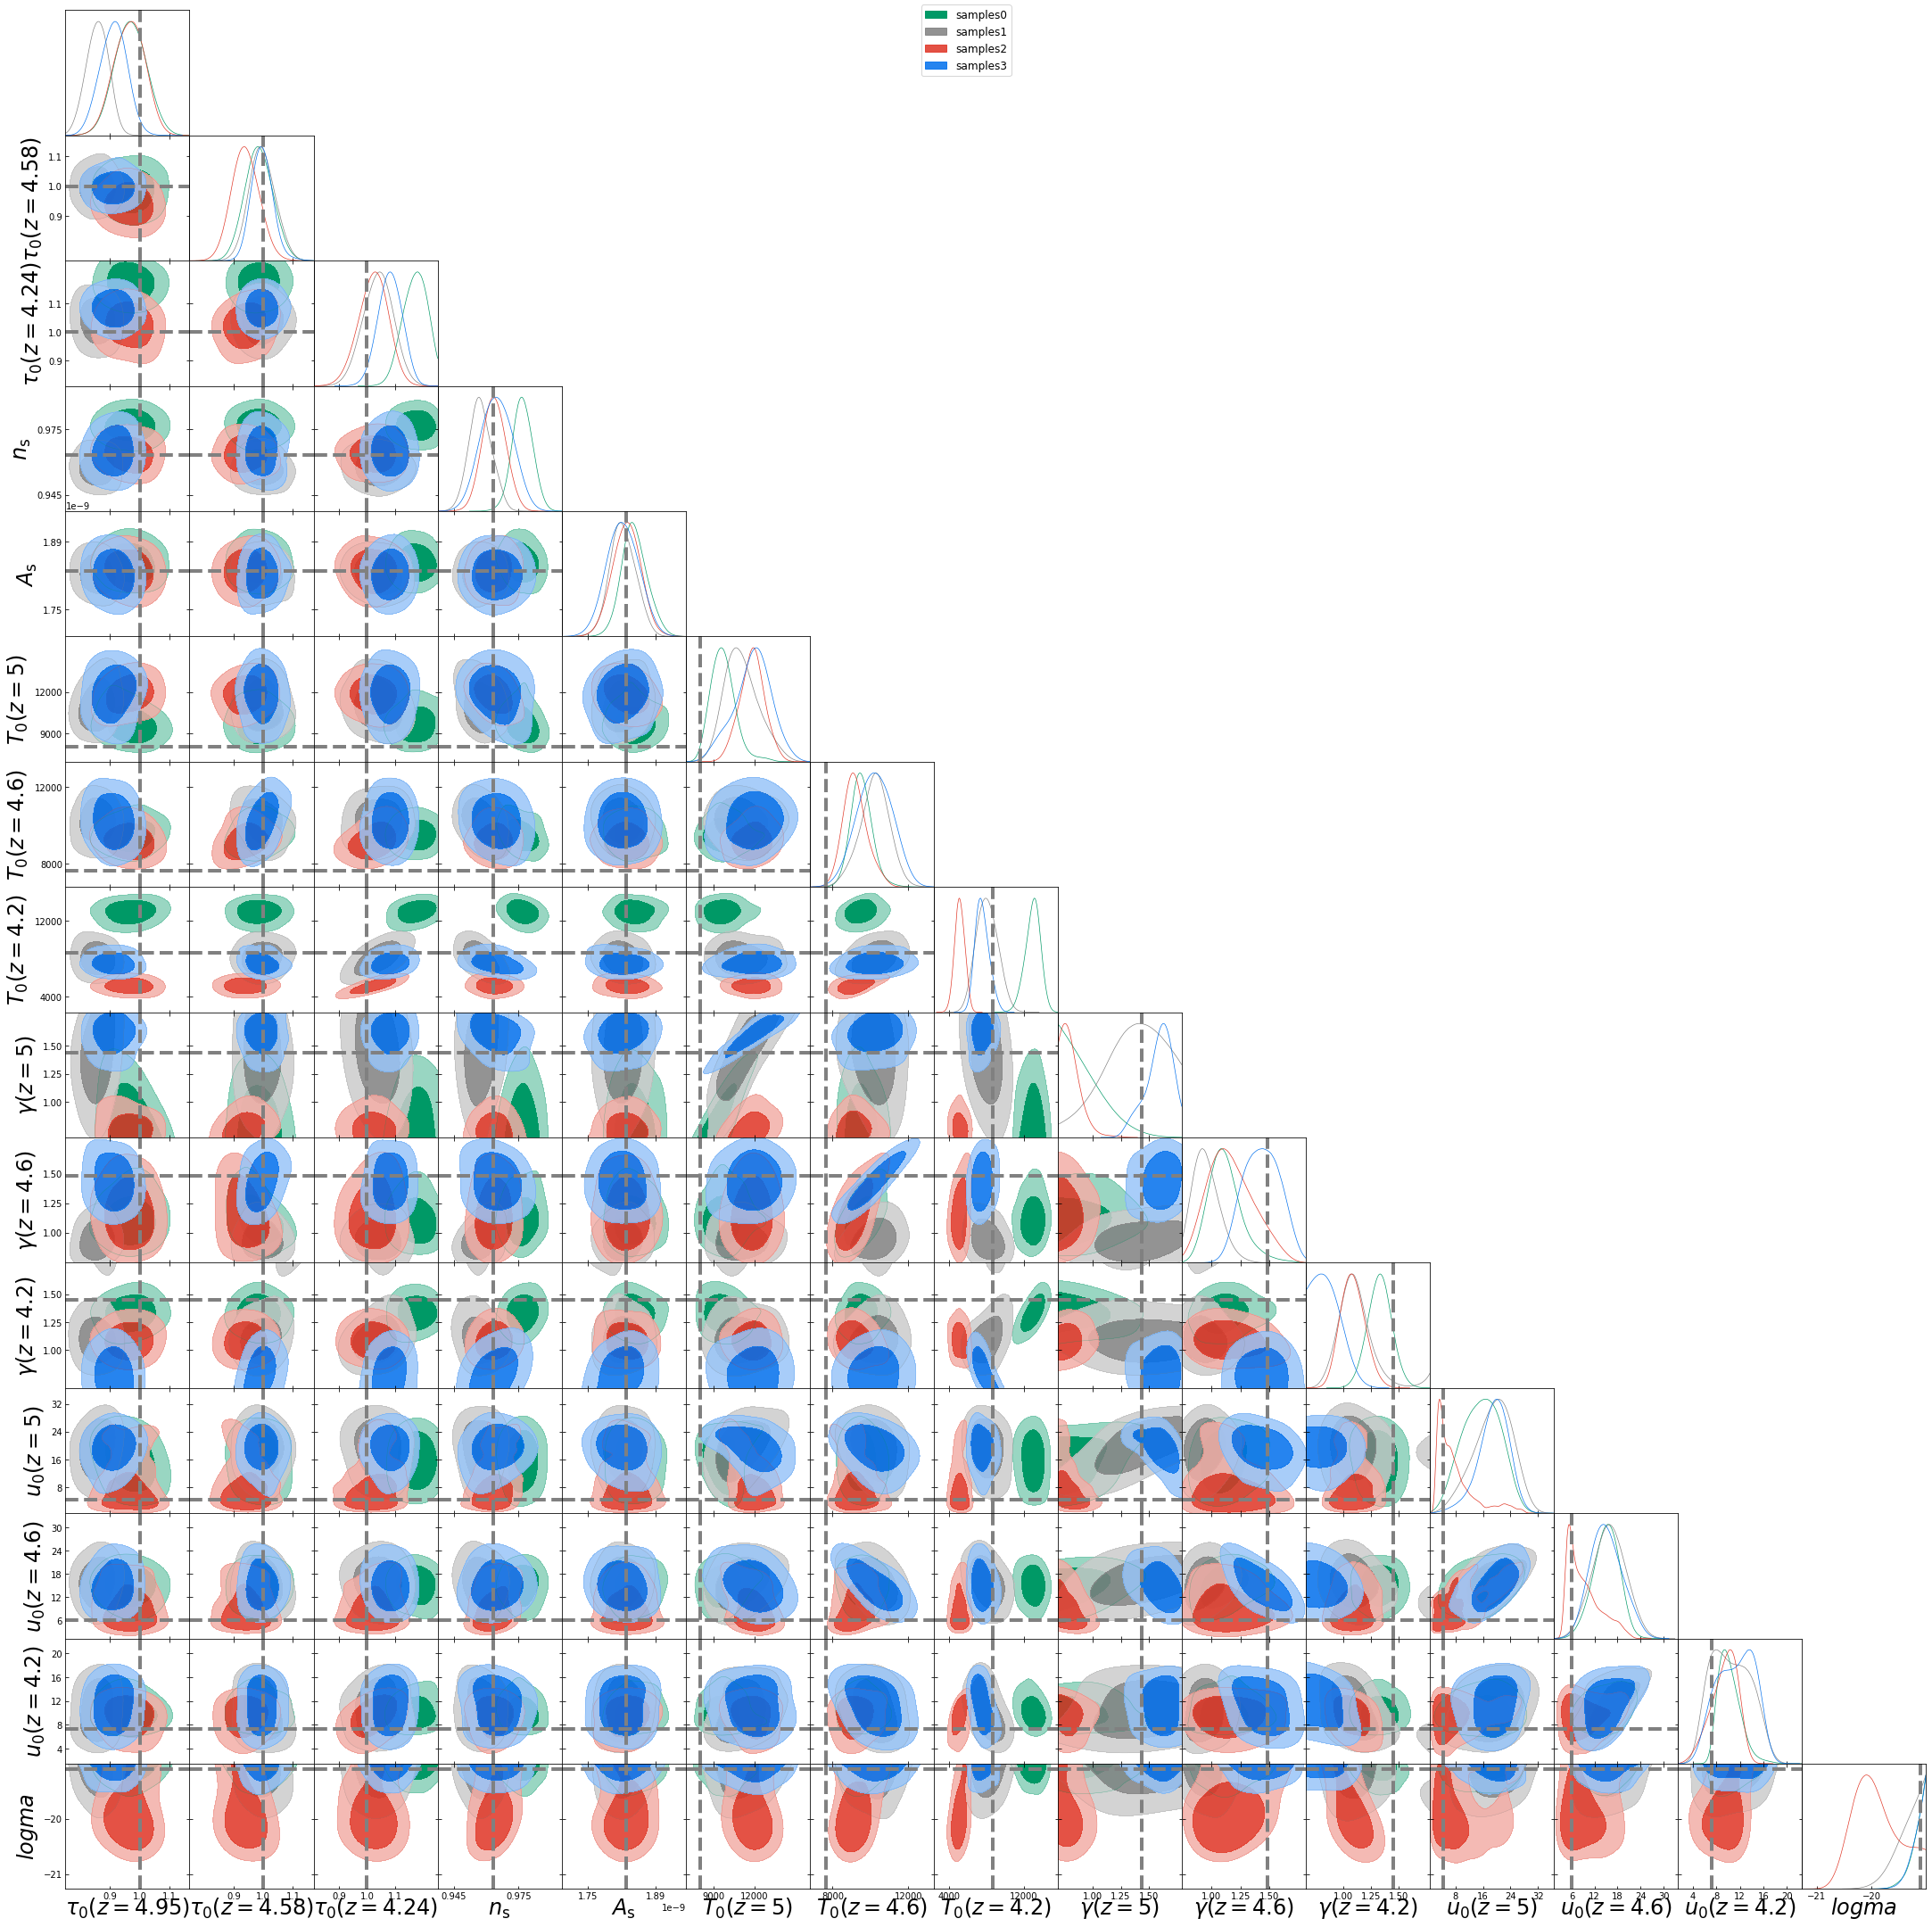

In [9]:
chainfiles = [None] * 4
chainfile_root = '/home/keir/Plots/nCDM'

chainfiles[0] = 'chain_ns0.964As1.83e-09heat_slope0heat_amp1omega_m0.321alpha0beta1gamma-1z_rei8T_rei2e+04_1_emu50_data_TDR_u0_15000_ULA_fit_convex_hull_omega_m_fixed_tau_Planck_T0_prior_no_jump_Tu0.txt'
chainfiles[1] = 'chain_ns0.964As1.83e-09heat_slope0heat_amp1omega_m0.321alpha0beta1gamma-1z_rei8T_rei2e+04_1_batch1_data_TDR_u0_15000_ULA_fit_convex_hull_omega_m_fixed_tau_Planck_T0_prior_no_jump_Tu0.txt'
chainfiles[2] = 'chain_ns0.964As1.83e-09heat_slope0heat_amp1omega_m0.321alpha0beta1gamma-1z_rei8T_rei2e+04_1_batch2_data_TDR_u0_15000_ULA_fit_convex_hull_omega_m_fixed_tau_Planck_T0_prior_no_jump_Tu0.txt'
chainfiles[3] = 'chain_ns0.964As1.83e-09heat_slope0heat_amp1omega_m0.321alpha0beta1gamma-1z_rei8T_rei2e+04_1_batch3_data_TDR_u0_15000_ULA_fit_convex_hull_omega_m_fixed_tau_Planck_T0_prior_no_jump_Tu0.txt'

for i, chainfile in enumerate(chainfiles):
    chainfiles[i] = os.path.join(chainfile_root, chainfile)

subplot_instance0, posterior_MCsamples0 = make_plot(chainfiles, None, true_parameter_values=test_params_mf,
          pnames=likelihood_instance.likelihood_parameter_names[:, 1],
          ranges=likelihood_instance.param_limits) #subplot_instance,


In [ ]:
posterior_MCsamples0 = cp.deepcopy(posterior_MCsamples)


In [17]:
#Get 1D marginalised posterior 1-sigma widths
two_sigma_widths = np.zeros(test_params_mf.shape[0])

for i in range(test_params_mf.shape[0]):
    if i < test_params_mf.shape[0] - 1:
        lower_limit = posterior_MCsamples0[-1].confidence(i, 0.16)
        upper_limit = posterior_MCsamples0[-1].confidence(i, 1. - 0.16)
    else:
        lower_limit = posterior_MCsamples0[-1].confidence(i, 0.32, upper=False)
        upper_limit = posterior_MCsamples0[-1].confidence(i, 0., upper=True)
    mean_value = posterior_MCsamples0[-1].getMeans()[i]
    two_sigma_widths[i] = upper_limit - lower_limit
    print(i, two_sigma_widths[i], lower_limit, upper_limit, mean_value)


0 0.09100792626891319 0.8648100731489599 0.955817999417873 0.9115761275486547
1 0.07115757296342784 0.9592061941664184 1.0303637671298462 0.9954456569515682
2 0.08665640524126639 1.0394687940929797 1.126125199334246 1.0820818087154198
3 0.015385188573112107 0.957346585595607 0.9727317741687191 0.9649300978186176
4 6.605800258473434e-11 1.7896390404498495e-09 1.8556970430345838e-09 1.8222482655205768e-09
5 2686.041770046668 10429.595916143679 13115.637686190346 11841.571343092904
6 1951.0885346469586 9274.15884412318 11225.247378770138 10224.38831335125
7 1489.8478118063758 6812.217522726216 8302.065334532592 7534.079372348357
8 0.24729262127102336 1.4566227458541348 1.7039153671251581 1.5875644416976862
9 0.3414780154262451 1.2571813648131411 1.5986593802393863 1.4292902012743802
10 0.26247521800477436 0.7275835393672968 0.9900587573720712 0.8603732743144752
11 8.401764069963772 15.127830993650328 23.5295950636141 19.17805810878242
12 8.622038826434315 10.884648519500894 19.50668734593

In [ ]:
#BO-1
'''Maximum of acquisition function =      fun: -353.914275727603
     jac: array([ 4.55890307e+02,  4.89668190e+02,  2.95751647e+01,  4.49569450e+02,
       -3.77147819e+02,  1.14626398e+04,  1.19608262e+02,  1.13920612e+02,
       -9.70749170e-01, -7.27263853e+01, -7.31309228e+01,  3.79277651e+01,
        2.01726948e+02,  2.63873142e+02,  5.39544658e+00, -3.13192612e+02])
 message: 'Converged (|x_n-x_(n-1)| ~= 0)'
    nfev: 58
     nit: 8
  status: 2
 success: True
       x: array([0.05      , 0.05      , 0.35450285, 0.60230512, 0.51105329,
       0.87024889, 0.30105636, 0.34192525, 0.40767761, 0.75969048,
       0.73606158, 0.66219663, 0.05      , 0.05      , 0.17386334,
       0.96686619])
[ 7.75000000e-01  7.75000000e-01  9.27251427e-01  9.57218987e-01
  1.86436927e-09  3.20917423e-01  5.73440366e+03  6.19803012e+03
  8.67488662e+03  1.52988653e+00  1.52905577e+00  1.43409983e+00
  2.42028785e+00  3.21983473e+00  7.22534864e+00 -1.90994014e+01]
Starting params = [ 7.7000e-01  7.8000e-01  9.3000e-01  9.6350e-01  1.8296e-09  3.2090e-01
  8.0220e+03  7.6510e+03  8.6730e+03  1.4400e+00  1.4800e+00  1.4500e+00
  4.5600e+00  6.1100e+00  7.2400e+00 -1.9100e+01]'''

acquire_max_params = np.array([ 7.75000000e-01,  7.75000000e-01,  9.27251427e-01,  9.57218987e-01,
  1.86436927e-09,  5.73440366e+03,  6.19803012e+03,
  8.67488662e+03,  1.52988653e+00,  1.52905577e+00,  1.43409983e+00,
  2.42028785e+00,  3.21983473e+00,  7.22534864e+00, -1.90994014e+01]) #3.20917423e-01,


In [ ]:
#BO-2
'''Maximum of acquisition function =      fun: 466.33557233140635
     jac: array([   835.13521076,   1378.2292001 ,     74.22009389,  -1044.33941601,
          617.11024273, -30423.03629286,  -1509.47687985,  -1065.44485448,
         -505.37934158,    446.88711114,    615.14414824,     68.26524555,
           47.24848282,    103.52549111,   -176.32960976,    504.28153031])
 message: 'Converged (|x_n-x_(n-1)| ~= 0)'
    nfev: 44
     nit: 3
  status: 2
 success: True
       x: array([0.49881831, 0.49746923, 0.49975384, 0.67043992, 0.48394349,
       0.8693801 , 0.46032991, 0.44578074, 0.40862626, 0.6783833 ,
       0.68887429, 0.67756742, 0.10901014, 0.1219898 , 0.17474122,
       0.96546435])
[ 9.99409157e-01  9.98734614e-01  9.99876922e-01  9.63691792e-01
  1.82912654e-09  3.20856607e-01  8.07690260e+03  7.69627939e+03
  8.69196272e+03  1.43934456e+00  1.47890392e+00  1.44994347e+00
  4.57812753e+00  6.08494821e+00  7.25450102e+00 -1.91036069e+01]
Starting params = [ 1.0000e+00  1.0000e+00  1.0000e+00  9.6350e-01  1.8296e-09  3.2090e-01
  8.0220e+03  7.6510e+03  8.6730e+03  1.4400e+00  1.4800e+00  1.4500e+00
  4.5600e+00  6.1100e+00  7.2400e+00 -1.9100e+01]'''

acquire_max_params = np.array([9.99409157e-01,  9.98734614e-01,  9.99876922e-01,  9.63691792e-01,
  1.82912654e-09,  8.07690260e+03,  7.69627939e+03,
  8.69196272e+03,  1.43934456e+00,  1.47890392e+00,  1.44994347e+00,
  4.57812753e+00,  6.08494821e+00,  7.25450102e+00, -1.91036069e+01]) #3.20856607e-01,


In [ ]:
#BO-3
'''Maximum of acquisition function =      fun: 553.858517550698
     jac: array([   630.78268795,   1457.30476788,    134.79570953,   -494.66806331,
          768.61398384, -24200.39953677,  -1180.70286135,   -839.26307752,
         -471.83947345,    340.22875752,   -106.66661865,     87.13019497,
         -434.07424073,   -342.5328714 ,   -136.77173456,     27.5519028 ])
 message: 'Converged (|x_n-x_(n-1)| ~= 0)'
    nfev: 37
     nit: 4
  status: 2
 success: True
       x: array([0.49875867, 0.49779218, 0.49969408, 0.66909322, 0.48380282,
       0.86950101, 0.45886623, 0.44487084, 0.40864958, 0.67830044,
       0.68889457, 0.67750003, 0.10922933, 0.12277553, 0.17474861,
       0.96510841])
[ 9.99379333e-01  9.98896089e-01  9.99847042e-01  9.63563856e-01
  1.82894366e-09  3.20865071e-01  8.05537576e+03  7.68315282e+03
  8.69238257e+03  1.43925228e+00  1.47892548e+00  1.44987401e+00
  4.58614273e+00  6.11621954e+00  7.25474638e+00 -1.91046748e+01]
Starting params = [ 1.0000e+00  1.0000e+00  1.0000e+00  9.6350e-01  1.8296e-09  3.2090e-01
  8.0220e+03  7.6510e+03  8.6730e+03  1.4400e+00  1.4800e+00  1.4500e+00
  4.5600e+00  6.1100e+00  7.2400e+00 -1.9100e+01]'''

'''Displaced optimisation parameters = [ 9.59389608e-01  9.88203136e-01  9.74316390e-01  9.59446665e-01
  1.85124857e-09  3.20871525e-01  9.86853588e+03  8.29949490e+03
  7.90645953e+03  1.24767917e+00  1.65222461e+00  1.49870853e+00
  1.11716194e+01  1.32436747e+01  8.93386324e+00 -1.94225812e+01]
0 0.9593896075706287 [0.75 1.25]
1 0.9882031363192021 [0.75 1.25]
2 0.9743163901436696 [0.75 1.25]
3 0.95944666499343 [0.9   0.995]
4 1.8512485666458976e-09 [1.2e-09 2.5e-09]
5 0.3208715246119656 [0.26 0.33]
6 9868.53588210762 [ 1306.64901767 16014.04365088]
7 8299.49490454025 [ 1265.31807371 15691.6058616 ]
8 7906.459533678113 [ 1336.50934672 19336.95173901]
9 1.247679171075966 [0.6839111  1.79749019]
10 1.6522246078280087 [0.74675074 1.80957627]
11 1.498708528239474 [0.75153156 1.78229528]
12 11.171619366799703 [ 0.59192435 37.15919428]
13 13.243674653419806 [ 1.22989057 41.02877384]
14 8.9338632394292 [ 1.4517912  34.65923769]
15 -19.422581168833826 [-22. -19.]'''

acquire_max_params = np.array([9.59389608e-01,  9.88203136e-01, 9.74316390e-01,  9.59446665e-01,
  1.85124857e-09,  9.86853588e+03,  8.29949490e+03,
  7.90645953e+03,  1.24767917e+00,  1.65222461e+00,  1.49870853e+00,
  1.11716194e+01,  1.32436747e+01,  8.93386324e+00, -1.94225812e+01]) #3.20871525e-01,


In [ ]:
#BO-4
'''Maximum of acquisition function =      fun: -272.4418152251446
     jac: array([-3.48887625e+001, -1.67137199e+002, -5.87289378e+001,
       -1.39209114e+003, -1.53483273e+002,  5.07870416e+004,
       -1.00842918e+003,  1.00000000e+107, -1.78378514e+001,
       -8.46358887e+001, -4.85464915e+002,  1.62874358e+001,
        2.80938826e+002,  7.54869865e+002,  1.98983741e+001,
       -1.43543099e+002])
 message: 'Linear search failed'
    nfev: 155
     nit: 13
  status: 4
 success: False
       x: array([0.32556211, 0.26167202, 0.43656616, 0.87920338, 0.46155888,
       0.87104606, 0.81465975, 0.86041566, 0.58323003, 0.58258102,
       0.58776091, 0.63988864, 0.15983808, 0.13734295, 0.24069258,
       0.7734021 ])
[ 9.12781054e-01  8.80836009e-01  9.68283079e-01  9.83524321e-01
  1.80002654e-09  3.20973224e-01  1.32881714e+04  1.36779220e+04
  1.18349079e+04  1.33266114e+00  1.37143805e+00  1.41110556e+00
  6.43676659e+00  6.69598649e+00  9.44457704e+00 -1.96797937e+01]
Starting params = [ 1.0000e+00  1.0000e+00  1.0000e+00  9.6350e-01  1.8296e-09  3.2090e-01
  8.0220e+03  7.6510e+03  8.6730e+03  1.4400e+00  1.4800e+00  1.4500e+00
  4.5600e+00  6.1100e+00  7.2400e+00 -1.9100e+01]'''

acquire_max_params = np.array([9.12781054e-01,  8.80836009e-01,  9.68283079e-01,  9.83524321e-01,
  1.80002654e-09,  1.32881714e+04,  1.36779220e+04,
  1.18349079e+04,  1.33266114e+00,  1.37143805e+00,  1.41110556e+00,
  6.43676659e+00,  6.69598649e+00,  9.44457704e+00, -1.96797937e+01]) #3.20973224e-01,


In [ ]:
#BO-5
'''Maximum of acquisition function =      fun: 556.8107548054978
     jac: array([   633.30357989,    880.19302211,    108.80394257,  -1300.99487023,
          145.46122884, -14833.55011942,  -1101.50990622,  -1416.40252878,
         -489.53841087,    364.94625419,    463.40310291,     86.36338862,
         -237.67819357,   -437.23146064,   -174.67903035,    109.4211143 ])
 message: 'Converged (|x_n-x_(n-1)| ~= 0)'
    nfev: 13
     nit: 2
  status: 2
 success: True
       x: array([0.49958882, 0.49924311, 0.49991975, 0.66873692, 0.48422695,
       0.86970227, 0.45740675, 0.44350873, 0.40790457, 0.67877881,
       0.68954573, 0.67759528, 0.10874471, 0.12241582, 0.17443552,
       0.96630068])
[ 9.99794408e-01  9.99621553e-01  9.99959873e-01  9.63530007e-01
  1.82949503e-09  3.20879159e-01  8.03391061e+03  7.66350263e+03
  8.67897200e+03  1.43978498e+00  1.47961754e+00  1.44997220e+00
  4.56842146e+00  6.10190344e+00  7.24434926e+00 -1.91010980e+01]
Starting params = [ 1.0000e+00  1.0000e+00  1.0000e+00  9.6350e-01  1.8296e-09  3.2090e-01
  8.0220e+03  7.6510e+03  8.6730e+03  1.4400e+00  1.4800e+00  1.4500e+00
  4.5600e+00  6.1100e+00  7.2400e+00 -1.9100e+01]'''

'''Displaced optimisation parameters = [ 8.94952819e-01  1.01235387e+00  8.91905107e-01  9.62107388e-01
  1.67684393e-09  3.20884381e-01  7.36115869e+03  5.70589652e+03
  7.38447355e+03  1.56982063e+00  9.99955882e-01  1.71317010e+00
  3.95935413e+00  1.43718233e+01  9.66991679e+00 -1.90000000e+01]
0 0.8949528194687116 [0.75 1.25]
1 1.0123538739680475 [0.75 1.25]
2 0.8919051068731405 [0.75 1.25]
3 0.9621073882943276 [0.9   0.995]
4 1.6768439330345296e-09 [1.2e-09 2.5e-09]
5 0.32088438125000607 [0.26 0.33]
6 7361.158686946542 [ 1306.64901767 16014.04365088]
7 5705.896524851392 [ 1265.31807371 15691.6058616 ]
8 7384.473548064406 [ 1336.50934672 19336.95173901]
9 1.5698206339868257 [0.6839111  1.79749019]
10 0.999955882286928 [0.74675074 1.80957627]
11 1.7131701037707234 [0.75153156 1.78229528]
12 3.9593541294778793 [ 0.59192435 37.15919428]
13 14.371823290644612 [ 1.22989057 41.02877384]
14 9.669916788918767 [ 1.4517912  34.65923769]
15 -19.0 [-22. -19.]'''

#acquire_max_params = np.array([1., 1., 1., 0.9621073882943276, 1.6768439330345296e-09, -0.0234909785220061,
#                               0.7800597178728893, 0.3209, 0.005208672042543639, 5.857951159999999,
#                               -1.2962823515582744, 11.88495172357593, 33578.31603031387])

acquire_max_params = np.array([0.8949528194687116, 1.0123538739680475, 0.8919051068731405, 0.9621073882943276,
                               1.6768439330345296e-09, 7361.158686946542, 5705.896524851392,
                               7384.473548064406, 1.5698206339868257, 0.999955882286928, 1.7131701037707234,
                               3.9593541294778793, 14.371823290644612, 9.669916788918767, -19.0]) #0.32088438125000607,


In [ ]:
#Add random displacement
displacement = npr.normal(scale=two_sigma_widths)

#displacement[-1] = -1. * np.absolute(displacement[-1])

print('Displacement vector =', displacement)


In [ ]:
acquire_max_params += displacement

if acquire_max_params[-1] > likelihood_instance.param_limits[-1, 1]:
    acquire_max_params[-1] = likelihood_instance.param_limits[-1, 1]

print('Displaced optimisation parameters =', acquire_max_params)

for i, param in enumerate(acquire_max_params):
    print(i, param, likelihood_instance.param_limits[i])
    assert param >= likelihood_instance.param_limits[i, 0]
    assert param <= likelihood_instance.param_limits[i, 1]


In [ ]:
acquire_max_params


In [10]:
#Convert nCDM parameters
log_mass_all = np.zeros((likelihood_instance.emulator.sample_params.shape[0], 1))
for i in range(50, log_mass_all.shape[0]):
    log_mass_all[i, 0] = lyl.ultra_light_axion_numerical_model_inverse(
                        likelihood_instance.emulator.sample_params[i, np.array([5, 6, 7])])
    print('log ULA mass =', log_mass_all[i, 0])

print(log_mass_all)


log mass = -19.099401399999866
log mass = -19.099401399999994
log mass = -19.615257721865063
log ULA mass = -19.099401399999866
log mass = -19.10360689999994
log mass = -19.103606900000006
log mass = -19.613154971865484
log ULA mass = -19.10360689999994
log mass = -19.42258119999988
log mass = -19.422581199999996
log mass = -19.453667821865288
log ULA mass = -19.42258119999988
log mass = -19.679793699999884
log mass = -19.679793699999987
log mass = -19.679793700001348
log ULA mass = -19.679793699999884
log mass = -18.99999999999999
log mass = -19.0
log mass = -19.664958421864807
log ULA mass = -18.99999999999999
log mass = -19.02999999999989
log mass = -19.02999999999999
log mass = -19.64995842186552
log ULA mass = -19.02999999999989
log mass = -19.02999999999989
log mass = -19.02999999999999
log mass = -19.64995842186552
log ULA mass = -19.02999999999989
log mass = -19.255491299999917
log mass = -19.2554913
log mass = -19.53721277186505
log ULA mass = -19.255491299999917
log mass = -1

In [13]:
#Plot optimisation simulations
likelihood_sample_params = np.concatenate((likelihood_instance.emulator.sample_params[:, np.array([0, 1])],
                                          likelihood_instance.emulator.measured_sample_params, log_mass_all), axis=1)

for a in range(3, test_params_mf.shape[0]):
    for b in range(a + 1):
        ax = subplot_instance0.subplots[a, b]
        if b < a:
            ax.scatter(likelihood_sample_params[:50, b - 3], likelihood_sample_params[:50, a - 3], s=200,
                       color='green', marker='+')
            ax.scatter(likelihood_sample_params[50:55, b - 3], likelihood_sample_params[50:55, a - 3], s=1000,
                       color='gray', marker='+')
            ax.scatter(likelihood_sample_params[55:60, b - 3], likelihood_sample_params[55:60, a - 3], s=1000,
                       color='red', marker='+')
            ax.scatter(likelihood_sample_params[60:, b - 3], likelihood_sample_params[60:, a - 3], s=1000,
                       color='blue', marker='+')


In [55]:
#Plot test points
for a in range(3, test_params_mf.shape[0]):
    for b in range(a + 1):
        ax = subplot_instance0.subplots[a, b]
        if b < a:
            ax.scatter(acquire_max_params[b - 0], acquire_max_params[a - 0], s=1000, color='black', marker='+')


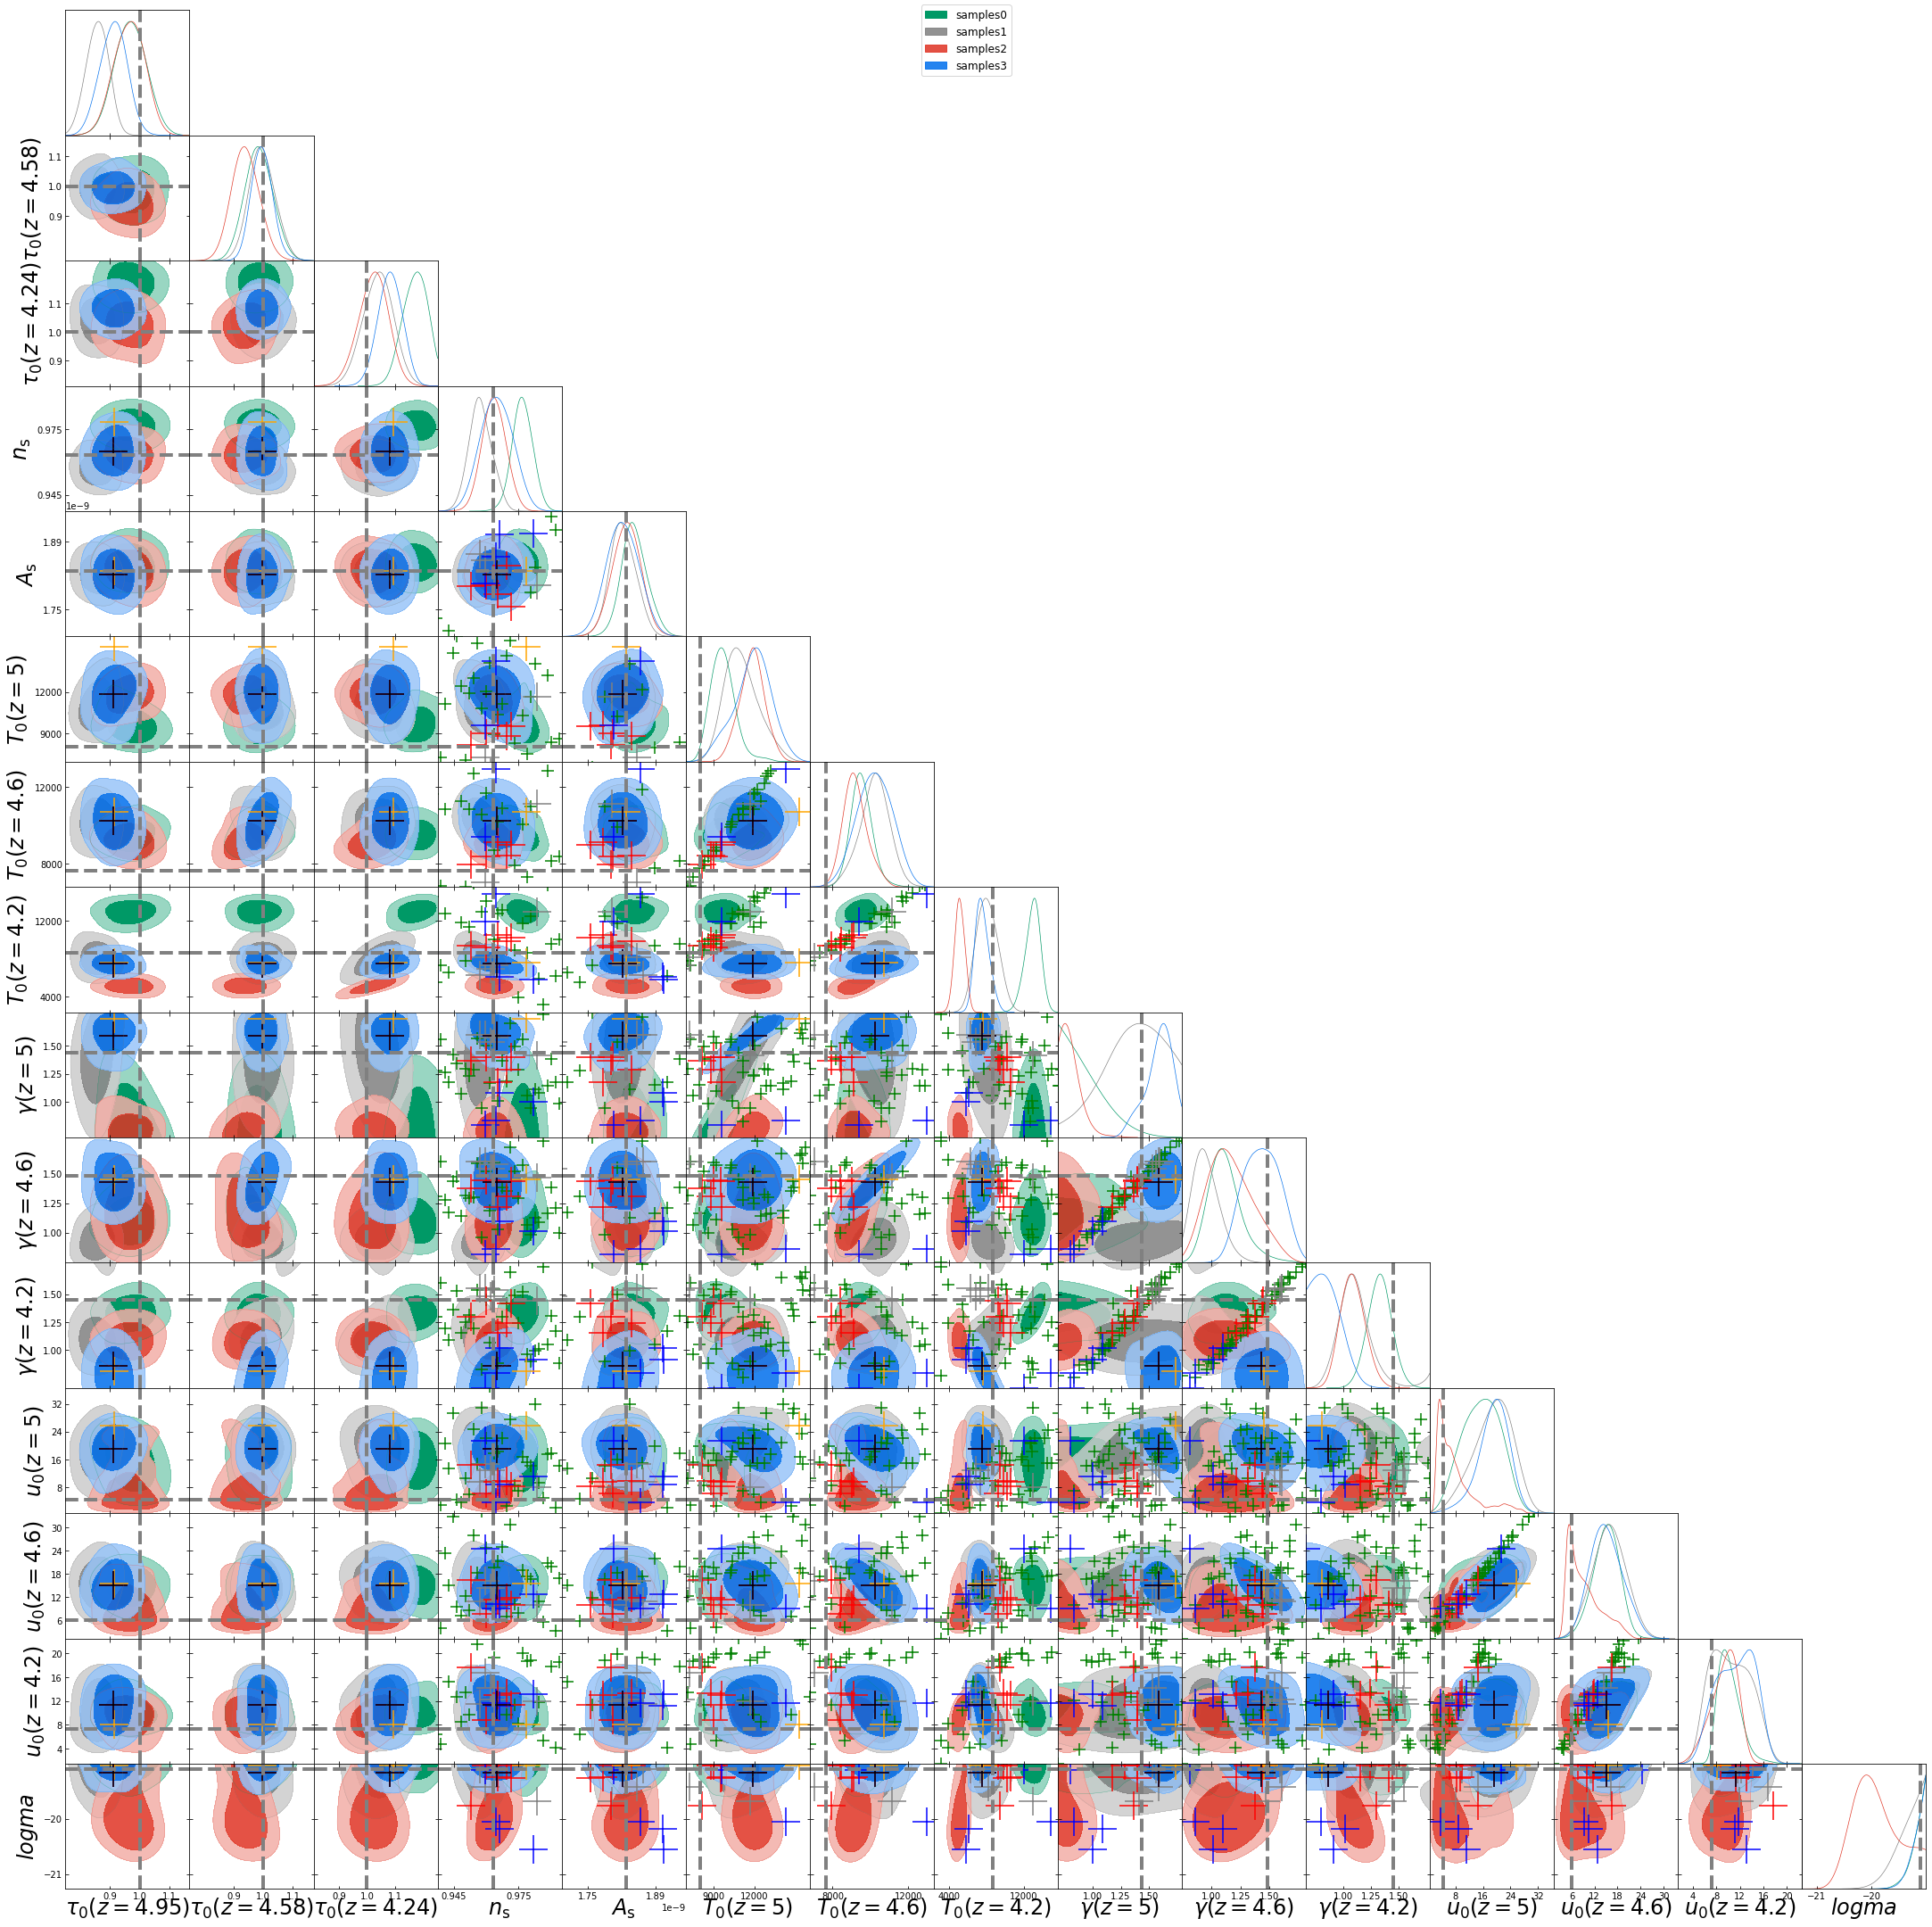

In [56]:
subplot_instance0.fig


In [57]:
#nCDM conversion
nCDM_parameters = likelihood_instance.dark_matter_model(np.array([acquire_max_params[-1],]),
                                                       likelihood_instance.param_limits_nCDM)
print('nCDM parameters =', nCDM_parameters)


nCDM parameters = [ 0.00614483  5.8314515  -1.33321395]


In [70]:
training_parameter_names = np.concatenate((np.array(['ns', 'As']),
        np.array([key for key in likelihood_instance.emulator.measured_param_names.keys()])[0::3],
        np.array(['alpha', 'beta', 'gamma']))) #Concentrate on z = 5
print(training_parameter_names)


['ns' 'As' 'T_0_z_5.0' 'gamma_z_5.0' 'u_0_z_5.0' 'alpha' 'beta' 'gamma']


In [63]:
#heat_amp
measured_parameters = acquire_max_params[np.array([3, 4, -10, -7, -4])] #3: -1] #Concentrate on z = 5
measured_parameters = np.concatenate((measured_parameters, nCDM_parameters))

training_parameter_names = np.concatenate((training_parameter_names, np.array(['heat_amp',])))

heat_amp = likelihood_instance.emulator.predict_parameters(measured_parameters,
                                                           training_parameter_names)
#np.array(['ns', 'As', 'T_0_z_4.6', 'gamma_z_4.6',
#            'u_0_z_4.6', 'alpha', 'beta', 'gamma', 'heat_amp']))
print('heat_amp =', heat_amp)


heat_amp = 2.040989183142649


In [65]:
#heat_slope
#measured_parameters = acquire_max_params[np.array([-6])] #, -3])]
training_parameter_names = np.concatenate((training_parameter_names,
                                           np.array(['heat_slope',])))

heat_slope = likelihood_instance.emulator.predict_parameters(measured_parameters,
                                                             training_parameter_names)
#np.array(['ns', 'As', 'T_0_z_4.6', 'gamma_z_4.6',
#                'u_0_z_4.6', 'alpha', 'beta', 'gamma', 'heat_slope']))
print('heat_slope =', heat_slope)


heat_slope = 0.32394987103032946


In [69]:
#z_rei
#measured_parameters = acquire_max_params[np.array([-9, -6, -3])]
training_parameter_names = np.concatenate((training_parameter_names, np.array(['z_rei',])))

z_rei= likelihood_instance.emulator.predict_parameters(measured_parameters,
                                                       training_parameter_names)
#np.array(['ns', 'As', 'T_0_z_4.6', 'gamma_z_4.6',
#                'u_0_z_4.6', 'alpha', 'beta', 'gamma', 'heat_slope']))
print('z_rei =', z_rei)


z_rei = 10.55883641650135


In [71]:
#T_rei
#measured_parameters = acquire_max_params[np.array([-9, -6, -3])]
training_parameter_names = np.concatenate((training_parameter_names, np.array(['T_rei',])))

T_rei= likelihood_instance.emulator.predict_parameters(measured_parameters,
                                                       training_parameter_names)
#np.array(['ns', 'As', 'T_0_z_4.6', 'gamma_z_4.6',
#                'u_0_z_4.6', 'alpha', 'beta', 'gamma', 'heat_slope']))
print('T_rei =', T_rei)


T_rei = 29800.742132458487


Text(0,0.5,'heat_amp')

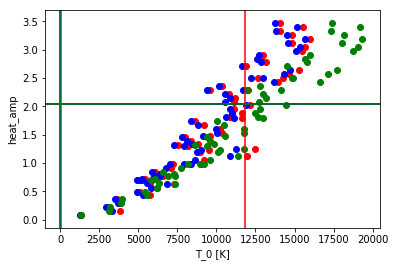

In [72]:
#Test parameter predictor
colors = ['red', 'blue', 'green']
for i in range(3):
    plt.scatter(likelihood_instance.emulator.measured_sample_params[:, i],
                likelihood_instance.emulator.sample_params[:, 3], color=colors[i])
    plt.axvline(x=measured_parameters[i+2], color=colors[i])
    plt.axhline(y=heat_amp, color=colors[i])
plt.xlabel(r'T_0 [K]')
plt.ylabel(r'heat_amp')


IndexError: index 8 is out of bounds for axis 0 with size 8

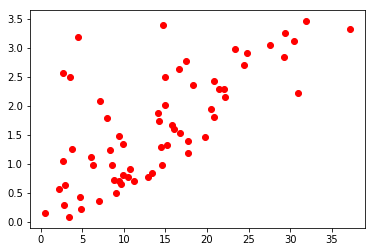

In [73]:
#Test heat_amp - u_0
for i in range(3):
    plt.scatter(likelihood_instance.emulator.measured_sample_params[:, i+6],
                likelihood_instance.emulator.sample_params[:, 3], color=colors[i])
    plt.axvline(x=measured_parameters[i+8], color=colors[i])
    plt.axhline(y=heat_amp, color=colors[i])
plt.xlabel(r'u_0 [eV/m_p]')
plt.ylabel(r'heat_amp')


Text(0,0.5,'heat_slope')

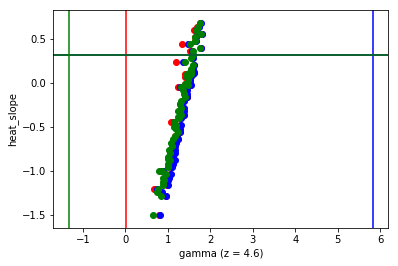

In [74]:
#Test heat_slope
for i in range(3):
    plt.scatter(likelihood_instance.emulator.measured_sample_params[:, i+3],
                likelihood_instance.emulator.sample_params[:, 2], color=colors[i])
    plt.axvline(x=measured_parameters[i+5], color=colors[i])
    plt.axhline(y=heat_slope, color=colors[i])
plt.xlabel(r'gamma (z = 4.6)')
plt.ylabel(r'heat_slope')


In [ ]:
#Test z_rei
for i in range(3):
    plt.scatter(likelihood_instance.emulator.measured_sample_params[:, i+6],
                likelihood_instance.emulator.sample_params[:, 8], color=colors[i])
    plt.axvline(x=measured_parameters[i+8], color=colors[i])
    plt.axhline(y=z_rei, color=colors[i])
plt.xlabel(r'u_0 [eV/m_p]')
plt.ylabel(r'z_rei')


In [ ]:
#Test T_rei
for i in range(3):
    plt.scatter(likelihood_instance.emulator.measured_sample_params[:, i+6],
                likelihood_instance.emulator.sample_params[:, 9], color=colors[i])
    plt.axvline(x=measured_parameters[i+8], color=colors[i])
    plt.axhline(y=T_rei, color=colors[i])
plt.xlabel(r'u_0 [eV/m_p]')
plt.ylabel(r'T_rei [K]')


In [41]:
#Fix omega_m for batch optimisation
#acquire_max_params[5] = 0.3209
acquire_max_omega_m = np.insert(acquire_max_params, 5, 0.3209)


In [42]:
#Parameters for batch optimisation
new_batch_params = np.insert(acquire_max_omega_m[3:-1], 3, nCDM_parameters).reshape(1, -1)
print('new batch params =', new_batch_params)


new batch params = [[ 9.78457627e-01  1.82959457e-09  3.20900000e-01  5.36792074e-03
   5.85320475e+00 -1.30314091e+00  1.52786739e+04  1.07183982e+04
   7.64170408e+03  1.73919799e+00  1.44974388e+00  8.09155503e-01
   2.56591006e+01  1.56591008e+01  8.03968585e+00]]


In [43]:
#Batch optimisation
likelihood_instance.gpemu.add_to_training_set(new_batch_params)


In [44]:
likelihood_instance.gpemu.gps[0].gp_updated.X.shape


(650, 10)

In [ ]:
#BO-6
'''Maximum of acquisition function =      fun: 53.4438442520769
     jac: array([ 2.23078825e+002,  1.59062103e+002, -8.62407632e+001,
        6.36436457e+002,  3.03108786e+002, -6.47389717e+002,
       -4.48774298e+002,  1.00000000e+107,  4.54110670e+002,
        1.87896228e+002, -6.08071105e-001,  4.85856469e+002,
       -9.32078166e+001,  7.65199246e+001,  5.32652791e+001])
 message: 'Linear search failed'
    nfev: 78
     nit: 3
  status: 4
 success: False
       x: array([0.48390246, 0.46951175, 0.50327184, 0.63135369, 0.46214433,
       0.53713706, 0.4978845 , 0.4064583 , 0.66215363, 0.66695593,
       0.68885575, 0.09678181, 0.17220223, 0.09741554, 0.99      ])
[ 9.91951231e-01  9.84755876e-01  1.00163592e+00  9.59978601e-01
  1.80078763e-09  9.20653570e+03  8.44794322e+03  8.65293847e+03
  1.42127154e+00  1.45560853e+00  1.46157907e+00  4.13097078e+00
  8.08334684e+00  4.68671267e+00 -1.90300000e+01]
Starting params = [ 1.0000e+00  1.0000e+00  1.0000e+00  9.6350e-01  1.8296e-09  8.0220e+03
  7.6510e+03  8.6730e+03  1.4400e+00  1.4800e+00  1.4500e+00  4.5600e+00
  6.1100e+00  7.2400e+00 -1.9100e+01]'''

acquire_max_params = np.array([9.91951231e-01,  9.84755876e-01,  1.00163592e+00,  9.59978601e-01,
  1.80078763e-09,  9.20653570e+03,  8.44794322e+03,  8.65293847e+03,
  1.42127154e+00,  1.45560853e+00,  1.46157907e+00,  4.13097078e+00,
  8.08334684e+00,  4.68671267e+00, -1.90300000e+01])


In [ ]:
#BO-7
'''Maximum of acquisition function =      fun: -206.22433194394605
     jac: array([ 1.84422021e+001, -1.03029095e+001, -2.16410427e+001,
       -5.12276713e+002, -1.37833035e+002,  7.50808766e+001,
       -7.99345514e+000,  4.87189908e+001,  1.44120561e+003,
        2.25741161e+001,  8.26522353e+000,  1.12565741e+003,
        1.00000000e+107,  5.71881174e+000, -7.53522301e+001])
 message: 'Linear search failed'
    nfev: 96
     nit: 7
  status: 4
 success: False
       x: array([0.30742452, 0.38835961, 0.66509082, 0.73199744, 0.49232438,
       0.58098999, 0.72165001, 0.42654971, 0.14654162, 0.55100671,
       0.53516665, 0.09791035, 0.32519374, 0.13573702, 0.99      ])
[ 9.03712259e-01  9.44179806e-01  1.08254541e+00  9.69539757e-01
  1.84002170e-09  9.85149802e+03  1.16760487e+04  9.01459289e+03
  8.47096776e-01  1.33237474e+00  1.30316193e+00  4.17223848e+00
  1.41722383e+01  5.95927089e+00 -1.90300000e+01]
Starting params = [ 1.0000e+00  1.0000e+00  1.0000e+00  9.6350e-01  1.8296e-09  8.0220e+03
  7.6510e+03  8.6730e+03  1.4400e+00  1.4800e+00  1.4500e+00  4.5600e+00
  6.1100e+00  7.2400e+00 -1.9100e+01]'''

acquire_max_params = np.array([9.03712259e-01,  9.44179806e-01,  1.08254541e+00,  9.69539757e-01,
  1.84002170e-09,  9.85149802e+03,  1.16760487e+04,  9.01459289e+03,
  8.47096776e-01,  1.33237474e+00,  1.30316193e+00,  4.17223848e+00,
  1.41722383e+01,  5.95927089e+00, -1.90300000e+01])


In [ ]:
#BO-8
'''Maximum of acquisition function =      fun: 83.14919692732083
     jac: array([ 3.38174360e+001,  2.42545184e-001, -3.63759938e+001,
        1.02915971e+002, -7.80143097e+000, -1.00725414e+002,
        1.29695110e+001,  1.00000000e+107,  4.65532594e+001,
        2.15838938e+001,  3.82987821e+001, -4.71722686e+001,
       -1.67824709e+001,  8.93518788e+001, -6.74165946e+001])
 message: 'Linear search failed'
    nfev: 65
     nit: 2
  status: 4
 success: False
       x: array([0.32388458, 0.38382756, 0.53990345, 0.75319801, 0.42745294,
       0.68906802, 0.78016153, 0.35383736, 0.53059561, 0.59006506,
       0.62705131, 0.14229551, 0.19811628, 0.08070037, 0.91483624])
[ 9.11942289e-01  9.41913779e-01  1.01995173e+00  9.71553811e-01
  1.75568882e-09  1.14410444e+04  1.25201529e+04  7.70573834e+03
  1.27477127e+00  1.37388695e+00  1.39787331e+00  5.79528267e+00
  9.11469740e+00  4.13164441e+00 -1.92554913e+01]
Starting params = [ 1.0000e+00  1.0000e+00  1.0000e+00  9.6350e-01  1.8296e-09  8.0220e+03
  7.6510e+03  8.6730e+03  1.4400e+00  1.4800e+00  1.4500e+00  4.5600e+00
  6.1100e+00  7.2400e+00 -1.9100e+01]'''

acquire_max_params = np.array([9.11942289e-01,  9.41913779e-01,  1.01995173e+00,  9.71553811e-01,
  1.75568882e-09,  1.14410444e+04,  1.25201529e+04,  7.70573834e+03,
  1.27477127e+00,  1.37388695e+00,  1.39787331e+00,  5.79528267e+00,
  9.11469740e+00,  4.13164441e+00, -1.92554913e+01])


In [ ]:
#BO-9
'''Maximum of acquisition function =      fun: 105.86834566611587
     jac: array([ 65.16044806, -14.14120447, -70.95566019, 173.56727966,
       -57.07852182,  22.23288931,  12.3025373 ,  69.39936412,
        39.87826318,  33.5497603 ,  93.3736672 , -37.92430761,
       -27.43833392, 166.94141323, -25.42016375])
 message: 'Converged (|x_n-x_(n-1)| ~= 0)'
    nfev: 13
     nit: 2
  status: 2
 success: True
       x: array([0.34891966, 0.38034175, 0.54643649, 0.7974558 , 0.44736692,
       0.67949588, 0.71067774, 0.38446584, 0.62373354, 0.56346548,
       0.68631414, 0.19953297, 0.19254701, 0.10399571, 0.96764465])
[ 9.24459828e-01  9.40170874e-01  1.02321825e+00  9.75758301e-01
  1.78157699e-09  1.13002630e+04  1.15177597e+04  8.25706458e+03
  1.37848772e+00  1.34561624e+00  1.45895928e+00  7.88830028e+00
  8.89304663e+00  4.90522332e+00 -1.90970660e+01]
Starting params = [ 1.0000e+00  1.0000e+00  1.0000e+00  9.6350e-01  1.8296e-09  8.0220e+03
  7.6510e+03  8.6730e+03  1.4400e+00  1.4800e+00  1.4500e+00  4.5600e+00
  6.1100e+00  7.2400e+00 -1.9100e+01]'''

'''Displaced optimisation parameters = [ 1.02723520e+00  9.71610128e-01  1.02184823e+00  9.65285282e-01
  1.78120697e-09  1.33211803e+04  1.21034739e+04  8.43816178e+03
  9.18601908e-01  8.98651202e-01  1.36865507e+00  5.21593563e+00
  1.05904478e+01  8.35363564e+00 -1.92509284e+01]
0 1.0272351955764856 [0.75 1.25]
1 0.9716101280698624 [0.75 1.25]
2 1.0218482343814652 [0.75 1.25]
3 0.96528528217733 [0.9   0.995]
4 1.7812069669757628e-09 [1.2e-09 2.5e-09]
5 13321.180306858965 [ 1306.64901767 16014.04365088]
6 12103.473889930816 [ 1265.31807371 15691.6058616 ]
7 8438.161780850929 [ 1336.50934672 19336.95173901]
8 0.9186019084084251 [0.6839111  1.79749019]
9 0.898651202282953 [0.74675074 1.80957627]
10 1.3686550745211263 [0.75153156 1.78229528]
11 5.21593563078898 [ 0.59192435 37.15919428]
12 10.590447794029911 [ 1.22989057 41.02877384]
13 8.353635642493034 [ 1.4517912  34.65923769]
14 -19.25092837864847 [-22. -19.]'''

acquire_max_params = np.array([1., 1., 1., 0.96528528217733, 1.7812069669757628e-09, 13321.180306858965, 12103.473889930816,
                               8438.161780850929, 0.9186019084084251, 0.898651202282953, 1.3686550745211263,
                               5.21593563078898, 10.590447794029911, 8.353635642493034, -19.25092837864847])


In [ ]:
#BO-10
'''Maximum of acquisition function =      fun: 106.53438708881907
     jac: array([ 65.68028823,  -9.12272213,  12.12806353, 312.38144373,
        24.38240756,   3.55909862, -26.24137636, 139.55538662,
        26.62237648,  25.30852186, 158.91932179, -46.94673805,
       -41.01592879, 201.76393463,  68.35029467])
 message: 'Converged (|x_n-x_(n-1)| ~= 0)'
    nfev: 39
     nit: 2
  status: 2
 success: True
       x: array([0.39827765, 0.37292372, 0.48905771, 0.76723122, 0.48379648,
       0.70422971, 0.67700922, 0.37577549, 0.63795413, 0.58962694,
       0.66434557, 0.18543167, 0.19561484, 0.11108361, 0.86767609])
[ 9.49138823e-01  9.36461858e-01  9.94528855e-01  9.72886966e-01
  1.82893542e-09  1.16640333e+04  1.10320479e+04  8.10063449e+03
  1.39432348e+00  1.37342130e+00  1.43631487e+00  7.37265415e+00
  9.01514295e+00  5.14059411e+00 -1.93969717e+01]
Starting params = [ 1.0000e+00  1.0000e+00  1.0000e+00  9.6350e-01  1.8296e-09  8.0220e+03
  7.6510e+03  8.6730e+03  1.4400e+00  1.4800e+00  1.4500e+00  4.5600e+00
  6.1100e+00  7.2400e+00 -1.9100e+01]'''

'''Displaced optimisation parameters = [ 9.15207209e-01  9.60939654e-01  1.11650541e+00  9.52857983e-01
  1.79857740e-09  1.21864178e+04  1.22274391e+04  5.73917061e+03
  9.35357583e-01  1.52341125e+00  1.22762379e+00  1.48133757e+01
  1.37674533e+01  1.05212092e+01 -1.97669151e+01]
0 0.9152072091730554 [0.75 1.25]
1 0.960939653550596 [0.75 1.25]
2 1.11650540923639 [0.75 1.25]
3 0.9528579826898936 [0.9   0.995]
4 1.7985774006228809e-09 [1.2e-09 2.5e-09]
5 12186.417786352915 [ 1306.64901767 16014.04365088]
6 12227.439105709218 [ 1265.31807371 15691.6058616 ]
7 5739.170612533635 [ 1336.50934672 19336.95173901]
8 0.9353575825102372 [0.6839111  1.79749019]
9 1.5234112511819602 [0.74675074 1.80957627]
10 1.2276237855692815 [0.75153156 1.78229528]
11 14.813375701414884 [ 0.59192435 37.15919428]
12 13.767453339270704 [ 1.22989057 41.02877384]
13 10.521209215279073 [ 1.4517912  34.65923769]
14 -19.76691508712584 [-22. -19.]'''

acquire_max_params = np.array([9.15207209e-01,  9.60939654e-01,  1.11650541e+00,  9.52857983e-01,
        1.79857740e-09,  1.21864178e+04,  1.22274391e+04,  5.73917061e+03,
        9.35357583e-01,  1.52341125e+00,  1.22762379e+00,  1.48133757e+01,
        1.37674533e+01,  1.05212092e+01, -1.97669151e+01])


In [75]:
#Add optimisation simulation
optimise_params = np.concatenate((acquire_max_params[np.array([3, 4])],
                                  np.array([heat_slope, heat_amp]),
                                  np.array([0.3209,]), nCDM_parameters,
                                  np.array([z_rei, T_rei]))).reshape(1, -1)
print('Parameters for optimisation simulation =', optimise_params)


Parameters for optimisation simulation = [[ 9.64930098e-01  1.82224828e-09  3.23949871e-01  2.04098918e+00
   3.20900000e-01  6.14483225e-03  5.83145150e+00 -1.33321395e+00
   1.05588364e+01  2.98007421e+04]]


In [76]:
likelihood_instance.emulator.gen_simulations(None, npart=512., box=10., samples=optimise_params,
                                             add_optimisation=True, dumpfile='emulator_params_batch4_2.json',
                                             simulation_flags=np.array([66,]))


In [ ]:
#Create new batch JSON
batch_params = cp.deepcopy(optimise_params)


In [ ]:
batch_params = np.concatenate((batch_params, optimise_params), axis=0)


In [ ]:
batch_params


In [ ]:
likelihood_instance.emulator.dump_optimisation_simulations(batch_params,
                                dumpfile='emulator_params_batch3.json')


In [ ]:
#Plot acquisition maxima vs. simulations run
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15., 5.))

axes[0].set_xlabel(r'T_0 (actual) [K]')
axes[0].set_ylabel(r'T_0 (requested) [K]')
axes[1].set_xlabel(r'gamma (actual)')
axes[1].set_ylabel(r'gamma (requested)')
axes[2].set_xlabel(r'u_0 (actual) [eV / m_p]')
axes[2].set_ylabel(r'u_0 (requested) [eV / m_p]')

s = 50
colour_array = np.array(['red', 'blue', 'green'])
label_array = np.array([r'z = 5', r'z = 4.6', r'z = 4.2'])

T0 = np.linspace(*likelihood_instance.emulator.measured_param_limits[0])
gamma = np.linspace(*likelihood_instance.emulator.measured_param_limits[3])
u0 = np.linspace(*likelihood_instance.emulator.measured_param_limits[6])

axes[0].plot(T0, T0, color='black', ls=':')
axes[1].plot(gamma, gamma, color='black', ls=':')
axes[2].plot(u0, u0, color='black', ls=':')


In [ ]:
for i, ax in enumerate(axes):
    for j in range(3):
        ax.scatter(likelihood_instance.emulator.measured_sample_params[s+9, (i*3) + j],
                   acquire_max_params[5 + (i*3) + j], color=colour_array[j]) #, label=label_array[j])
    #ax.legend()

fig


In [ ]:
likelihood_instance.emulator.measured_sample_params[s+10]
